#Simulation for knockout training:
**Two-layer linear network, different bottleneck**

Please see "script_linearnetwork_samebottleneck" for a simple case of knockout training with helpful documentation.

Here, we are interested to see how knockout training performs when our KO network's bottleneck has fewer hidden units than those of the ground truth model's bottleneck. This is likely the case for the fruit fly visual system, where we cannot silence all possible cell types between the optic lobe and the central brain.

Our prediction is that having extra hidden units in the ground truth model's bottleneck will not interfere too strongly with the KO network's ability to identify the behavioral contributions and responses of the inactivated hidden units. The KO network will fail to identify the hidden units that were not inactivated (e.g., the extra hidden units).

This simulation follows that in Extended Data Figure 2d-e in our paper "Mapping model units to visual neurons reveals population code for social behaviour.", Cowley, B.R., Calhoun, A.J., Rangarajan, N., Ireland, E., Turner, M.H., Pillow, J.W. and Murthy, M., 2024. *Nature*, pp.1-9.


In [1]:
# import statements and helper functions

import numpy as np
import tensorflow as tf

from keras import backend as K
from keras import utils
from keras.models import Model
from keras import layers

from keras.layers import Activation, BatchNormalization, Dense, Flatten, Input, Multiply
from keras.optimizers import Adam

import matplotlib.pyplot as plt

### HELPER FUNCTIONS

def initialize_network(num_input_variables=48, num_hidden_units=8):
  # initializes a two-layer linear network that outputs a single variable
  #
  # INPUT:
  #  num_input_variables: (int), number of input feature variables (default=48)
  #  num_hidden units: (int), number of hidden units in middle layer (default=8)
  # OUTPUT:
  #  model: (Keras instance), outputs a Keras model

  x_input = Input(shape=(num_input_variables,), name='input')
  x_mask = Input(shape=(num_hidden_units,), name='mask')

  # define network  (input includes a 'mask' to inactivate or "knock out" certain hidden units)
  x = Dense(units=num_hidden_units, name='bottleneck')(x_input)
  x = Multiply()([x, x_mask])
  x = Dense(units=1, name='output')(x)

  model = Model(inputs=[x_input, x_mask], outputs=x)
  optimizer = Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  # Note: model takes as input a list of x_input and a mask of 1s and 0s
  return model


def generate_data(model, num_input_variables=48, num_hidden_units=8, num_samples=1000, iunit_inactivated=None):
  # generates data (input, hidden unit responses, and output) for a given model
  #     (can silence a particular hidden unit, which could potentially lead to different output)
  #
  # INPUT:
  #  model: (Keras instance), model of two-layer linear network (most likely the ground truth model)
  #  num_input_variables: (int), number of input feature variables for X (default=48)
  #  num_hidden_units: (int), number of hidden units in ground truth model (default=8)
  #  num_samples: (int), number of samples to generate (default=1000)
  #  iunit_inactivated: (0 to num_hidden_units-1, or 'None'), index of hidden unit to be inactivated
  #            if None or > num_hidden_units - 1, no units are inactivated
  #
  # OUTPUT:
  #	x_input: (num_samples, num_input_variables), generated input features
  #	responses_bottleneck: (num_samples, num_hidden_units), hidden unit responses to x_input
  #	y: (num_samples,), output behavior (with a small amount of added Gaussian noise)

  x_input = np.random.standard_normal(size=(num_samples, num_input_variables))
  mask_input = np.ones((num_samples,num_hidden_units))

  responses_bottleneck = get_hiddenunit_responses(model, x_input, num_hidden_units)
  # model_hiddenunits = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)
  # responses_bottleneck = model_hiddenunits.predict([x_input, mask_input], verbose=False)

  if iunit_inactivated != None and iunit_inactivated < num_hidden_units and iunit_inactivated >= 0:
    mask_input[:,iunit_inactivated] = 0.

  y = np.squeeze(model.predict([x_input, mask_input], verbose=False))
  y = y + 0.5 * np.random.standard_normal((y.shape)) # add Gaussian noise

  return x_input, responses_bottleneck, y


def get_hiddenunit_responses(model, x_input, num_hidden_units=8):
  # gets hidden unit responses from model to input features x_input
  #
  # INPUT:
  #  model: (Keras instance), model of two-layer linear network (most likely the ground truth model)
  #  x_input: (num_samples, num_input_variables), input features
  #  num_hidden_units: (int), number of hidden units in middle layer (default=8)
  #
  # OUTPUT:
  #  responses_bottleneck: (num_samples, num_hidden_units), hidden unit responses to x_input

  num_samples = x_input.shape[0]
  mask_input = np.ones((num_samples, num_hidden_units))
  model_hiddenunits = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)
  responses_bottleneck = model_hiddenunits.predict([x_input, mask_input], verbose=False)

  return responses_bottleneck


def compute_R2(y_test, y_hat, R2_type='cod'):
  # computes fraction of explained variance (R^2)
  #
  # INPUT:
  #	 y_test: (num_samples,), observed output (from ground truth model)
  #	 y_hat: (num_samples,), model predictions of observed output
  #	 R2_type: ('cod' or 'pearson'),
  #				-->coefficient of determination (R^2 can be negative); pearson-->rho^2 (always positive)
  # OUTPUT:
  #  R2: (float), prediction performance between y and y_hat

  if R2_type == 'cod':
    R2 = 1 - np.sum((y_hat - y_test)**2) / np.sum((y_test - np.mean(y_test))**2)
  else:
    R2 = np.corrcoef(y_test, y_hat)[0,1]**2

  return R2


# Generate data from ground truth model

Ground truth model: 48 input vars., 16 hidden units, 1 output unit

**Training data:**
We will generate 16 x 1k samples for each hidden unit, but only the first
eight hidden units will be inactivated. We will also have 1k samples for control, making it 17 'sessions' or 'datasets' in total.

**Test data:**
Exact same as training data.

In [2]:
# Initialize ground truth model and generate training and test data

seed_index = 314159
utils.set_random_seed(seed_index)

## initialize ground truth network and generate data
num_input_variables = 48
num_hidden_units = 16
num_inactivated_units = 8
num_samples = 1000  # num samples per dataset

model_ground_truth = initialize_network(num_input_variables, num_hidden_units)

## generate training data
Xs_train = []  # datasets kept as lists, where Xs_train[i] corresponds
ys_train = []  #     to the ith hidden unit inactivated
               #     (and Xs_train[num_hidden_units+1] --> control)

for iunit in range(num_inactivated_units): # inactivate first 8 hidden units
  X, _, y = generate_data(model_ground_truth, num_input_variables, num_hidden_units, iunit_inactivated=iunit)
  Xs_train.append(X)
  ys_train.append(y)

for iunit in range(num_inactivated_units, num_hidden_units+1):  # do not inactivate last 8 hidden units and +1 for control
  X, _, y = generate_data(model_ground_truth, num_input_variables, num_hidden_units, iunit_inactivated=None)
  Xs_train.append(X)
  ys_train.append(y)

# generate test data
Xs_test = []
responses_test = []
ys_test = []

for iunit in range(num_inactivated_units): # inactivate first 8 hidden units
  X, responses, y = generate_data(model_ground_truth, num_input_variables, num_hidden_units, iunit_inactivated=iunit)
  Xs_test.append(X)
  responses_test.append(responses)
  ys_test.append(y)

for iunit in range(num_inactivated_units, num_hidden_units+1):  # do not inactivate last 8 hidden units and +1 for control
  X, responses, y = generate_data(model_ground_truth, num_input_variables, num_hidden_units, iunit_inactivated=None)
  Xs_test.append(X)
  responses_test.append(responses)
  ys_test.append(y)

# unit test: check sizes
print('Xs_train length =', end=' ')
print(len(Xs_train))
print('X_train shape: ', end=' ')
print(Xs_train[-1].shape)
print('ys_train length =', end=' ')
print(len(ys_train))
print('y_train shape: ', end=' ')
print(ys_train[-1].shape)
print('Xs_test length =', end=' ')
print(len(Xs_test))
print('X_test shape: ', end=' ')
print(Xs_test[-1].shape)
print('responses_test length =', end=' ')
print(len(responses_test))
print('responses_test shape: ', end=' ')
print(responses_test[-1].shape)
print('ys_test length =', end=' ')
print(len(ys_test))
print('y_test shape: ', end=' ')
print(ys_test[-1].shape)


Xs_train length = 17
X_train shape:  (1000, 48)
ys_train length = 17
y_train shape:  (1000,)
Xs_test length = 17
X_test shape:  (1000, 48)
responses_test length = 17
responses_test shape:  (1000, 16)
ys_test length = 17
y_test shape:  (1000,)


# Train and evaluate KO network

In [3]:
## train KO model

K.clear_session()  # clears space (including ground truth model)
utils.set_random_seed(seed_index)
model_KO = initialize_network(num_input_variables, num_hidden_units)

num_epochs = 25
for iepoch in range(num_epochs): # number of passes through entire dataset
  iunits = np.arange(num_inactivated_units+1) # +1 for control
  iunits[-1] = 16  # set to index the control data
  np.random.shuffle(iunits)  # shuffles which units are trained each epoch
  for iunit in iunits:
    # create mask
    num_samples = Xs_train[iunit].shape[0]
    mask = np.ones((num_samples, num_hidden_units))
    if iunit < num_inactivated_units:  # only inactivate first 8 hidden units
      mask[:,iunit] = 0.

    model_KO.fit([Xs_train[iunit], mask], ys_train[iunit], batch_size=64, verbose=False, shuffle=True)

  # check perf on test set, control data and one silenced set
  mask = np.ones((num_samples, num_hidden_units))
  y_hat = np.squeeze(model_KO.predict([Xs_test[-1], mask], verbose=False))
  R2_control = compute_R2(ys_test[-1], y_hat, R2_type='cod')

  mask[:,0] = 0.
  y_hat = np.squeeze(model_KO.predict([Xs_test[0], mask], verbose=False))
  R2_unit0 = compute_R2(ys_test[0], y_hat, R2_type='cod')
  print('epoch {:d}, R2 control = {:f}, R2 unit0 = {:f}'.format(iepoch, R2_control, R2_unit0))


## behavior prediction performance for KO network
R2s_behavior_KO = []
for iunit in range(num_hidden_units+1):
  num_samples = Xs_test[iunit].shape[0]
  mask = np.ones((num_samples, num_hidden_units))
  if iunit < num_inactivated_units:  # hidden unit was silenced (not control or extra units)
    mask[:,iunit] = 0.

  y_hat = np.squeeze(model_KO.predict([Xs_test[iunit], mask], verbose=False))
  R2 = compute_R2(ys_test[iunit], y_hat, R2_type='cod')
    # we use coefficient of determination "cod" here to account for
    #  differences in overall mean, std. dev., and sign

  if iunit < num_hidden_units:
    print('behavior prediction, unit {:d}, behavior R2 = {:f}'.format(iunit, R2))
  else:
    print('behavior prediction, control, behavior R2 = {:f}'.format(R2))
    # (we will plot these later)

  R2s_behavior_KO.append(R2)


## neural prediction performance for KO network
# (tested on control data --- e.g., recording activity of control animal)
R2s_neural_KO = []
for iunit in range(num_hidden_units):
  responses_model = get_hiddenunit_responses(model_KO, Xs_test[-1], num_hidden_units)

  R2 = compute_R2(responses_test[-1][:,iunit], responses_model[:,iunit], R2_type='pearson')
    # we use pearson correlation**2 here to ignore differences
    #  in overall mean, std. dev., and sign, as we are not interested
    #  in predicting, e.g., average firing rates but rather the information content

  print('unit {:d}, neural R2 = {:f}'.format(iunit, R2))
  R2s_neural_KO.append(R2)


epoch 0, R2 control = 0.889887, R2 unit0 = 0.876984
epoch 1, R2 control = 0.911808, R2 unit0 = 0.880311
epoch 2, R2 control = 0.875441, R2 unit0 = 0.856787
epoch 3, R2 control = 0.903842, R2 unit0 = 0.869381
epoch 4, R2 control = 0.868954, R2 unit0 = 0.879030
epoch 5, R2 control = 0.897012, R2 unit0 = 0.857792
epoch 6, R2 control = 0.875914, R2 unit0 = 0.866389
epoch 7, R2 control = 0.876045, R2 unit0 = 0.889541
epoch 8, R2 control = 0.910752, R2 unit0 = 0.879368
epoch 9, R2 control = 0.897863, R2 unit0 = 0.885780
epoch 10, R2 control = 0.907183, R2 unit0 = 0.875697
epoch 11, R2 control = 0.910973, R2 unit0 = 0.886667
epoch 13, R2 control = 0.907601, R2 unit0 = 0.861229
epoch 14, R2 control = 0.913740, R2 unit0 = 0.876326
epoch 15, R2 control = 0.909159, R2 unit0 = 0.856468
epoch 16, R2 control = 0.909440, R2 unit0 = 0.868580
epoch 17, R2 control = 0.887790, R2 unit0 = 0.902650
epoch 18, R2 control = 0.894360, R2 unit0 = 0.905042
epoch 19, R2 control = 0.906359, R2 unit0 = 0.855783
epo

# Train and evaluate noKO network

In [4]:
## train noKO model

K.clear_session()  # clears space (including ground truth model)
utils.set_random_seed(seed_index)
model_noKO = initialize_network(num_input_variables, num_hidden_units)

num_epochs = 25
for iepoch in range(num_epochs): # number of passes through entire dataset
  iunits = np.arange(num_inactivated_units+1) # +1 for control
  iunits[-1] = 16  # set to index the control data
  np.random.shuffle(iunits)  # shuffles which units are trained each epoch
  for iunit in iunits:
    # create mask
    num_samples = Xs_train[iunit].shape[0]
    mask = np.ones((num_samples, num_hidden_units))
      # (no inactivation---mask is all ones)

    model_noKO.fit([Xs_train[iunit], mask], ys_train[iunit], batch_size=64, verbose=False)

  # check perf on test set, control data and one silenced set
  mask = np.ones((num_samples, num_hidden_units))
  y_hat = np.squeeze(model_noKO.predict([Xs_test[-1], mask], verbose=False))
  R2_control = compute_R2(ys_test[-1], y_hat, R2_type='cod')

  y_hat = np.squeeze(model_noKO.predict([Xs_test[0], mask], verbose=False))
  R2_unit0 = compute_R2(ys_test[0], y_hat, R2_type='cod')
  print('epoch {:d}, R2 control = {:f}, R2 unit0 = {:f}'.format(iepoch, R2_control, R2_unit0))


## behavior prediction performance for KO network
R2s_behavior_noKO = []
for iunit in range(num_hidden_units+1):
  num_samples = Xs_test[iunit].shape[0]
  mask = np.ones((num_samples, num_hidden_units))

  y_hat = np.squeeze(model_noKO.predict([Xs_test[iunit], mask], verbose=False))
  R2 = compute_R2(ys_test[iunit], y_hat, R2_type='cod')
    # we use coefficient of determination "cod" here to account for
    #  differences in overall mean, std. dev., and sign

  if iunit < num_hidden_units:
    print('behavior prediction, unit {:d}, behavior R2 = {:f}'.format(iunit, R2))
  else:
    print('behavior prediction, control, behavior R2 = {:f}'.format(R2))
    # (we will plot these later)

  R2s_behavior_noKO.append(R2)


## neural prediction performance for KO network
# (tested on control data --- e.g., recording activity of control animal)
R2s_neural_noKO = []
for iunit in range(num_hidden_units):
  responses_model = get_hiddenunit_responses(model_noKO, Xs_test[-1], num_hidden_units)

  R2 = compute_R2(responses_test[-1][:,iunit], responses_model[:,iunit], R2_type='pearson')
    # we use pearson correlation**2 here to ignore differences
    #  in overall mean, std. dev., and sign, as we are not interested
    #  in predicting, e.g., average firing rates but rather the information content

  print('unit {:d}, neural R2 = {:f}'.format(iunit, R2))
  R2s_neural_noKO.append(R2)

epoch 0, R2 control = 0.871175, R2 unit0 = 0.648156
epoch 1, R2 control = 0.914019, R2 unit0 = 0.746112
epoch 2, R2 control = 0.812027, R2 unit0 = 0.599148
epoch 3, R2 control = 0.896688, R2 unit0 = 0.735442
epoch 4, R2 control = 0.803631, R2 unit0 = 0.626416
epoch 5, R2 control = 0.897963, R2 unit0 = 0.678161
epoch 6, R2 control = 0.860708, R2 unit0 = 0.731389
epoch 7, R2 control = 0.851884, R2 unit0 = 0.655660
epoch 8, R2 control = 0.879442, R2 unit0 = 0.743013
epoch 9, R2 control = 0.856008, R2 unit0 = 0.628589
epoch 10, R2 control = 0.891520, R2 unit0 = 0.713724
epoch 11, R2 control = 0.900816, R2 unit0 = 0.689452
epoch 12, R2 control = 0.768686, R2 unit0 = 0.886123
epoch 13, R2 control = 0.911015, R2 unit0 = 0.784791
epoch 14, R2 control = 0.910569, R2 unit0 = 0.738656
epoch 15, R2 control = 0.903544, R2 unit0 = 0.801720
epoch 16, R2 control = 0.902688, R2 unit0 = 0.737006
epoch 17, R2 control = 0.806231, R2 unit0 = 0.893764
epoch 18, R2 control = 0.845694, R2 unit0 = 0.877795
epo

# Plot $R^2$ results

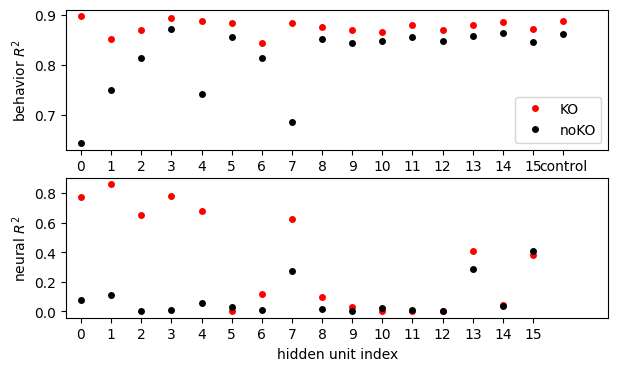

In [5]:
## plot R2 results
f = plt.figure(figsize=(7,4))

# R2s behavior
plt.subplot(2,1,1)
plt.plot(R2s_behavior_KO, '.r', mew=0., ms=10, label='KO')
plt.plot(R2s_behavior_noKO, '.k', mew=0., ms=10, label='noKO')
plt.xlabel('unit inactivated')
plt.ylabel('behavior $R^2$')
plt.xlim([-0.5,17.5])
plt.xticks(np.arange(17), labels=[i for i in range(16)] + ['control'])

plt.legend()

# R2s neural
plt.subplot(2,1,2)
plt.plot(R2s_neural_KO, '.r', mew=0., ms=10)
plt.plot(R2s_neural_noKO, '.k', mew=0., ms=10)
plt.xlabel('hidden unit index')
plt.ylabel('neural $R^2$')
plt.xlim([-0.5,17.5])  # include control spot so it matches with R2s_behavior
plt.xticks(np.arange(16), labels=np.arange(16))

f.show()


The KO network does a good job at predicting behavior, even for units that were not inactivated (top plot, red dots above black dots, hidden units 8-15). This is likely because the noKO network must trade off predicting the behavior of the inactivated hidden units (units 0-7) with the control behavior.

The KO network predicts the responses of the hidden units that were inactivated (units 0-7, red dots above black in bottom plot). Units 5 and 6 are poorly predicted likely because units 5 and 6 do not strongly contribute to behavior (see top plot).

Overall, knockout training still works in the setting where we cannot inactivate all possible hidden units---a setting more common in systems neuroscience.